# Ejemplos de algoritmos genéticos
---

Tutorial completo: http://deap.readthedocs.io/en/master/tutorials/basic/part1.html

Referencia DEAP: http://deap.readthedocs.io/en/master/api/tools.html


## Problema OneMax

En este problema de optimización nos encontramos con un vector de 100 valores binarios, por lo que el número de posibles casos es de $2^{100}$. La tarea consiste en encontrar el vector con mayor número de $1$'s.

Ante de meternos a resolver el problema mediante algoritmos genéticos vamos a intentar resolverlo solamente mediante azar. Vamos a crear un millón de vectores de cien elementos y veamos cuál es el mayor fitness que conseguimos.

In [39]:
import numpy as np

max = 0
for _ in range(1_000_000):
    v = np.random.randint(0,2,100)
    s = np.sum(v)
    if s > max:
        max = s
        
print(max)

74


En este caso el mayor valor ha sido 73. Recuerda que la probabilidad de que obtengamos de forma aleatoria un vector con cien unos es de:

$$\frac{1}{2^{100}}$$

Las principales clases de DEAP y que vamos a utilizar son:

- <code>base</code> acceso al *toolbox* y a las funciones de *fitness*.
- <code>creator</code> permite crear los tipos (*types*).
- <code>tools</code> acceso a los operadores.
- <code>algorithms</code> prepara las iteraciones de los algoritmos genéticos.

In [1]:
import random
import numpy
from deap import base, creator, tools, algorithms

### Fitness

La clase "Fitness" proporcionada es una **clase abstracta** que necesita un atributo de pesos para ser funcional. Un "fitness" a minimizar se construye utilizando pesos negativos, mientras que para maximizar debemos coloar pesos positivos. Es posible que la función de fitness incluya varias funciones internas donde unas deban maximizarse y otras minimizarse. Por esta razón el parámetro "weights" es una tupla.

La función *create()* tiene al menos dos argumentos, un nombre para la clase recién creada y una clase base. Cualquier argumento subsiguiente se convierte en un **atributo de la clase**.

### Individuos

El primer individuo que crearemos será una simple lista que contiene flotantes. Para producir este tipo de individuo, necesitamos crear una clase *Individual*, usando el creador, que heredará del tipo de lista estándar y tendrá un atributo fitness.

In [2]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

Vemos que <code>Individual</code> es una clase que hereda de <code>list</code> y tiene un método llamado <code>fitness</code>. Podemos crear un individuo <code>ind</code> a partir de <code>creator.Individual</code>, como se muestra a continuación:

In [3]:
ind = creator.Individual([1, 0, 1, 1, 0])

print(ind)
print(type(ind))
print(type(ind.fitness))

[1, 0, 1, 1, 0]
<class 'deap.creator.Individual'>
<class 'deap.creator.FitnessMax'>


El valor del <code>fitness</code> de un individuo se calculará simplemente sumando todos sus elementos.

In [4]:
def evalOneMax(individual):
    return sum(individual),

Ahora registraremos varias funciones para crear los atributos de los individuos, los propios individuos y la población. También registraremos las funciones para evaluar los individuos, cruzarlos, mutarlos y seleccionarlos.

In [5]:
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=100)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.03)
toolbox.register("select", tools.selTournament, tournsize=3)

bit = toolbox.attr_bool()
pop = toolbox.population(n=50)

# print("bit is of type %s and has value\n%s" % (type(bit), bit))
# print("ind is of type %s and contains %d bits\n%s" % (type(ind), len(ind), ind))
# print("pop is of type %s and contains %d individuals\n%s" % (type(pop), len(pop), pop))

Por ejemplo, veamos cómo crearíamos un individuo y cómo lo mutaríamos. Observa la línea <code>temp = ind[:]</code>, con este "truco" logramos crear una nueva copia de la lista. Si hubiéramos hecho <code>temp = ind</code>, entonces <code>temp</code> e <code>ind</code> serían el mismo objeto, cosa que no queremos.

In [6]:
import numpy as np

ind = toolbox.individual()
temp = ind[:]
print(ind)
toolbox.mutate(temp)
print(np.array(ind) - np.array(temp))

print(id(ind))
print(id(temp))

[1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  1  0  0  0  0 -1  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0]
4532618728
4531819272


Otra forma de hacer lo mismo pero con el método <code>clone</code> de <code>tolbox</code>.

In [7]:
mutant = toolbox.clone(ind)
print(mutant is ind)
print(mutant == ind)

False
True


### Hall of fame

Si queremos mantener durante toda la evolución del algoritmo los mejores individuos obtenidos hasta el momento, debemos crear un objeto "hall of fame". En este caso, vamos a mantener cuatro. También podemos ir mostrando estadístias a medida que el algoritmo avanza.

In [40]:
hof = tools.HallOfFame(4)

stats = tools.Statistics(lambda indiv: indiv.fitness.values)
stats.register("avg", numpy.mean)
stats.register("min", numpy.min)
stats.register("max", numpy.max)

pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=100, stats=stats, halloffame=hof, verbose=True)

gen	nevals	avg  	min	max
0  	0     	98.08	93 	99 
1  	32    	98.08	92 	100
2  	23    	98.66	95 	100
3  	25    	98.32	93 	100
4  	27    	98.48	93 	100
5  	29    	98.76	93 	100
6  	21    	99.26	95 	100
7  	34    	99.14	95 	100
8  	39    	99.16	92 	100
9  	23    	99.36	93 	100
10 	26    	99.38	93 	100
11 	36    	99.3 	95 	100
12 	35    	99.4 	94 	100
13 	36    	99.46	94 	100
14 	37    	99.42	94 	100
15 	32    	99.4 	94 	100
16 	20    	99.16	90 	100
17 	36    	99.26	94 	100
18 	31    	99.4 	95 	100
19 	27    	99.72	96 	100
20 	28    	99.28	94 	100
21 	34    	99.38	93 	100
22 	30    	99.46	95 	100
23 	24    	99.66	96 	100
24 	25    	99.86	97 	100
25 	33    	99.2 	95 	100
26 	35    	99.64	95 	100
27 	25    	99.28	95 	100
28 	33    	99.42	95 	100
29 	28    	99.5 	94 	100
30 	31    	99.22	95 	100
31 	24    	99.74	95 	100
32 	30    	99.42	95 	100
33 	32    	99.66	96 	100
34 	25    	99.6 	92 	100
35 	33    	99.5 	95 	100
36 	27    	99.42	94 	100
37 	30    	99.64	96 	100
38 	26    	99.48	94 	100


Best individual is: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 with fitness: (100.0,)


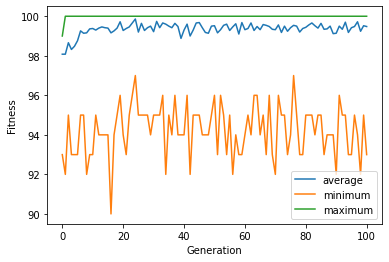

In [41]:
print("Best individual is: %s\n with fitness: %s" % (hof[0], hof[0].fitness))

import matplotlib.pyplot as plt

gen, avg, min_, max_ = logbook.select("gen", "avg", "min", "max")
plt.plot(gen, avg, label="average")
plt.plot(gen, min_, label="minimum")
plt.plot(gen, max_, label="maximum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="lower right")
plt.show()

In [10]:
hof.keys

[deap.creator.FitnessMax((98.0,)),
 deap.creator.FitnessMax((99.0,)),
 deap.creator.FitnessMax((99.0,)),
 deap.creator.FitnessMax((99.0,))]

Comparemos, por tanto, este resultado con el intento que hicimos al principio de resolverlo por simple azar. Solo por azar computamos un millón de soluciones y obtuvimos un *fitness* de 73, mediante algoritmos genéticos sólo computamos 5000 soluciones (100 individuos x 50 generaciones) y obtuvimos un *fitness* de 99.

---
**Resetear kernel**

---

## Problema de la mochila

El **problema de la mochila** es un problema clásico dentro de la IA. Consiste en lo siguiente: existe un número determinado de objetos que tienen un valor y un peso propios. En nuestra mochila solo podemos llevar hasta un peso máximo, por lo tanto, el problema consiste en escoger los objetos que minimicen el peso y maximicen el valor. Es un problema NP-completo.

In [1]:
import random
import numpy
from deap import base, creator, tools, algorithms

creator.create("Fitness", base.Fitness, weights=(-1.0, 1.0))  # minimizamos el peso y maximizamos el valor
creator.create("Individual", set, fitness=creator.Fitness)

In [2]:
IND_INIT_SIZE = 5
MAX_ITEM = 50  # Número máximo de objetos en la mochila
MAX_WEIGHT = 50  # Peso máximo en la mochila
NBR_ITEMS = 20  # Número total de objetos

Crearemos el conjunto de objetos del que podremos escoger cuáles meter en la mochila.

In [3]:
# Create the item dictionary: item name is an integer, and value is 
# a (weight, value) 2-tuple.

items = {}
# Create random items and store them in the items' dictionary.
for i in range(NBR_ITEMS):
    items[i] = (random.randint(1, 10), random.uniform(0, 100))  # (peso, valor)

In [4]:
items

{0: (3, 40.21973789030577),
 1: (5, 14.82673705642511),
 2: (4, 17.84809746774294),
 3: (2, 77.10800522420402),
 4: (9, 68.28988567929494),
 5: (1, 68.86370295584337),
 6: (7, 13.961059341269245),
 7: (8, 31.01136831834118),
 8: (2, 80.16372253099942),
 9: (8, 34.13362867121229),
 10: (6, 96.59866206156678),
 11: (2, 22.525889266595158),
 12: (3, 58.49950981707295),
 13: (10, 32.64928028147466),
 14: (5, 58.69033290714722),
 15: (10, 77.2728251346083),
 16: (4, 89.62514697548662),
 17: (6, 14.444314021405402),
 18: (2, 7.477817620888938),
 19: (9, 76.88910569305926)}

Las siguientes líneas crean la población inicial del individuos. Con <code>toolbox.attr_item</code> escogemos un objeto, entre 0 y NBR_ITEMS. La función <code>toolbox.individual</code> itera IND_INIT_SIZE veces para ir añadiendo objetos al individuo. Observa que los individuos pueden tener IND_INIT_SIZE objetos o menos. Eso se debe a que si aleatoriamente se vuelve a escoger el mismo objeto, éste no se repite dentro del conjunto (set). Por último, <code>toolbox.population</code>  crea una función para generar una lista de individuos.

In [5]:
toolbox = base.Toolbox()
toolbox.register("attr_item", random.randrange, NBR_ITEMS)  # Objeto a escoger, entre 0 y NBR_ITEMS-1
toolbox.register("individual", tools.initRepeat, creator.Individual, 
    toolbox.attr_item, IND_INIT_SIZE)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

Evaluamos un individuo como la suma total del peso y valor de sus objetos.

In [6]:
def evalKnapsack(individual):
    weight = 0.0
    value = 0.0
    for item in individual:
        weight += items[item][0]
        value += items[item][1]
    if len(individual) > MAX_ITEM or weight > MAX_WEIGHT:
        return 10000, 0             # Ensure overweighted bags are dominated
    return weight, value

Para cruzar dos individuos y generar otros dos nuevos podemos usar las funciones de **intersección** y **diferencia simétrica** propias de los conjuntos. Por ejemplo, si tuviéramos los individuos {16, 9, 18, 3} y {3, 4, 13, 17, 18} los individuos resultantes serían {3, 18} (intersección) y {4, 9, 13, 16, 17} (diferencia).

In [7]:
def cxSet(ind1, ind2):
    """Apply a crossover operation on input sets. The first child is the
    intersection of the two sets, the second child is the difference of the
    two sets.
    """
    temp = set(ind1)                # Used in order to keep type

    ind1.intersection_update(ind2)
    ind2.symmetric_difference_update(temp)
    
    return ind1, ind2

In [8]:
def mutSet(individual):
    """Mutation that pops or add an element."""
    if random.random() < 0.5:
        if len(individual) > 0:     # We cannot pop from an empty set
            individual.remove(random.choice(sorted(tuple(individual))))
    else:
        individual.add(random.randrange(NBR_ITEMS))
    return individual,

In [9]:
toolbox.register("evaluate", evalKnapsack)
toolbox.register("mate", cxSet)
toolbox.register("mutate", mutSet)
toolbox.register("select", tools.selNSGA2)

In [10]:
def main():
    NGEN = 50
    MU = 50
    LAMBDA = 100
    CXPB = 0.7
    MUTPB = 0.2

    pop = toolbox.population(n=MU)
    hof = tools.ParetoFront()
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean, axis=0)
    stats.register("std", numpy.std, axis=0)
    stats.register("min", numpy.min, axis=0)
    stats.register("max", numpy.max, axis=0)

    algorithms.eaMuPlusLambda(pop, toolbox, MU, LAMBDA, CXPB, MUTPB, NGEN, stats, halloffame=hof)
    #algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=100, stats=stats, halloffame=hof, verbose=True)

    return pop, stats, hof

In [11]:
pop, stats, hof = main()

gen	nevals	avg                        	std                      	min                        	max                        
0  	50    	[ 24.56       223.65118954]	[ 6.52735781 49.03010369]	[ 11.         147.27473174]	[ 37.         387.91418152]
1  	86    	[ 10.9        139.66364096]	[ 11.58835623 128.17872618]	[0. 0.]                    	[ 35.         387.91418152]
2  	91    	[ 5.28       75.83985356]  	[ 10.69960747 133.39604745]	[0. 0.]                    	[ 39.        477.5393285]  
3  	92    	[ 5.32       77.44312801]  	[ 10.68352002 132.95591463]	[0. 0.]                    	[ 39.        477.5393285]  
4  	89    	[ 6.9        99.77271384]  	[ 11.854535   145.74231859]	[0. 0.]                    	[ 39.        477.5393285]  
5  	95    	[ 5.36       79.73462148]  	[ 11.44160828 140.8811111 ]	[0. 0.]                    	[ 39.        477.5393285]  
6  	92    	[ 5.54       86.43899891]  	[ 11.41264211 142.29245413]	[0. 0.]                    	[ 39.        477.5393285]  
7  	89    	[  7.44  

# Hall of fame


In [12]:
hof.items

[Individual(),
 {5},
 {8},
 {5, 8},
 {3, 8},
 {3, 5, 8},
 {3, 5, 8, 11},
 {3, 5, 8, 12},
 {3, 5, 8, 16},
 {0, 3, 5, 8, 12},
 {3, 5, 8, 12, 16},
 {3, 5, 8, 11, 12, 16},
 {0, 3, 5, 8, 12, 16},
 {0, 3, 5, 8, 11, 12, 16},
 {3, 5, 8, 10, 12, 16},
 {3, 5, 8, 10, 11, 12, 16},
 {0, 3, 5, 8, 10, 12, 16},
 {0, 3, 5, 8, 10, 11, 12, 16},
 {3, 5, 8, 10, 11, 12, 14, 16},
 {0, 3, 5, 8, 10, 12, 14, 16},
 {0, 3, 5, 8, 10, 11, 12, 14, 16},
 {0, 2, 3, 5, 8, 10, 11, 12, 14, 16},
 {3, 5, 8, 10, 11, 12, 14, 16, 19},
 {0, 3, 5, 8, 10, 12, 14, 16, 19},
 {0, 3, 5, 8, 10, 12, 14, 15, 16},
 {0, 3, 5, 8, 10, 11, 12, 14, 16, 19},
 {0, 3, 5, 8, 10, 11, 12, 14, 15, 16},
 {0, 2, 3, 5, 8, 10, 11, 12, 14, 16, 19},
 {0, 1, 2, 3, 5, 8, 10, 11, 12, 14, 16, 19},
 {0, 2, 3, 5, 8, 9, 10, 11, 12, 14, 16, 19}]

In [13]:
import matplotlib.pyplot as plt

x = []
y = []

for v in items.values():
    x.append(v[0])
    y.append(v[1])


plt.scatter(x, y)
plt.show()

<Figure size 640x480 with 1 Axes>

# Frente de Pareto

Se denomina **óptimo de Pareto** a aquel punto de equilibrio en el que ninguno de los agentes afectados podrá mejorar su situación sin reducir el bienestar de cualquiera de los otros agentes ([Wikipedia](https://es.wikipedia.org/wiki/Eficiencia_de_Pareto)). 

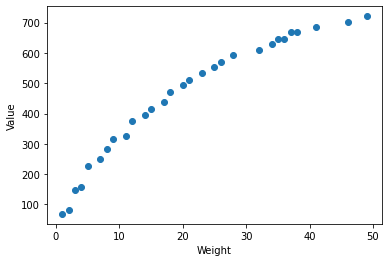

In [14]:
x = []
y = []

for hof_item in hof.items:
    if len(hof_item) > 0:
        weight = 0
        value = 0
        for i in hof_item:
            w, v = items[i]
            weight += w
            value += v
        x.append(weight)
        y.append(value)
            
plt.xlabel("Weight")
plt.ylabel("Value")
plt.scatter(x, y)
plt.show()